In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
df_kb = pd.read_csv('data/massIVE-KB/df_kb_filter.csv')
df_uni = pd.read_csv('data/uniprot/df_uni.csv')

# Guide
  - STRIP_PEPTIDE의 spectral count 정리 기준
    - PTM_PEPTIDE(SEQ)도 protein에서 ID된것이긴 하니까 STRIP_PEPTIDE 기준으로 detect 된 것으로 판단해야 한다.
  - point 1
      - PTM_PEPTIDE와 noPTM_PEPTIDE를 STRIP_PEPTIDE로 만들 때, spectral count 합쳐야 할까?  
        - protien 기준에서 id peptide를 판단할 때, PTM없이 판단하므로 합치는게 맞다.
      - 결론 : 맞다.
  - point 2
      - PTM_PEPTIDE 의 m/z, intensity 와 noPTM_PEPTIDE 의 m/z, intensity가 다를텐데 prosit 기준값은?
          - m/z, intensity 는 noPTM_PEPTIDE것으로 사용한다.
          - 물론, noPTM_PEPTIDE와 겹치지 않으면 STRIP_PEPTIDE의 스펙트럼 사용
      - 결론 : PTM_PEPTIDE의 STRIP_PEPTIDE서열이 noPTM에 있는 경우 noPTM 스펙트럼 사용  
        없는 경우, best score의 스펙트럼 사용
  - point 3
      - CHARGE 마다 spectral count 다른데, 합쳐야할까?
      - 1과 같은 의미로 합치는게 맞다.
      - 다만, m/z, intensity 비교를 위해 charge별 하나를 정해야하므로 별도로 유지한다.

In [3]:
# protein check
pc2prot = dict()
for pep, c, prot in df_kb[['STRIP_PEPTIDE', 'CHARGE', 'PROTEIN']].values:
    if (pep, c) not in pc2prot:
        pc2prot[(pep, c)]=set()
    for p in prot.split(';'):
        pc2prot[(pep, c)].add(p)
    
print('STRIP precursor which has protein >2 cnt : ', 
      len([_ for _ in pc2prot.values() if len(_) >=2]))

for (p, c), v in pc2prot.items():
    pc2prot[(p, c)] = ';'.join(list(v))

STRIP precursor which has protein >2 cnt :  69082


In [4]:
# ptm spectral count merge (plus)
pc2cnt = dict()
for c, p, cnt in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SPECTRAL_CNT']].values:
    if (p, c) not in pc2cnt:
        pc2cnt[(p, c)] = 0
    pc2cnt[(p, c)] += cnt

In [5]:
# spectrum check
# 84만개의 no PTM PEPTIDE
pc2mz = dict()
pc2int = dict()
for p, c, m, i in df_kb[['SEQ', 'CHARGE', 'MZ', 'INTENSITY']].values:  
    if '+' not in p:
        pc2mz[(p, c)] = m
        pc2int[(p, c)] = i

# spectrum check
# 20만개의 PTM PEPTIDE
noptm_pc = {(_, c) for c, _ in df_kb[['CHARGE', 'SEQ']].values if '+' not in _}
whole_pc = {(_, c) for c, _ in df_kb[['CHARGE', 'STRIP_PEPTIDE']].values}
ptm_pc_candi = {k:set() for k in list(whole_pc.difference(noptm_pc))}

# PTM_PEPTIDE candidate
# ptm_pc_candi = (STRIP_PEPTIDE, CHARGE):(PTM_PEPTIDE, CHARGE)
for c, p, seq in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SEQ']].values:
    if (p, c) in ptm_pc_candi:
        ptm_pc_candi[(p, c)].add((seq, c))

pc2score_look = {(p, c):score for p, c, score in df_kb[['SEQ', 'CHARGE', 'SCORE']].values}
pc2mz_look = {(p, c):mz for p, c, mz in df_kb[['SEQ' ,'CHARGE', 'MZ']].values}
pc2int_look = {(p, c):i for p, c, i in df_kb[['SEQ' ,'CHARGE', 'INTENSITY']].values}

for k, v in ptm_pc_candi.items():
    if len(v)==1:
        v = list(v)[0]
        pc2mz[k] = pc2mz_look[v]
        pc2int[k] = pc2int_look[v]
    else:  # choose high SCORE's SEQ
        ptm_seqs = {ptm_seq:pc2score_look[ptm_seq] for ptm_seq in v}
        best_v = sorted(ptm_seqs.items(), key=lambda x: x[1], reverse=True)[0][0]  # 내림차순
        pc2mz[k] = pc2mz_look[best_v]
        pc2int[k] = pc2int_look[best_v]

In [6]:
pc = {(p,c) for p, c in df_kb[['STRIP_PEPTIDE', 'CHARGE']].values}
df_ided_peptide = pd.DataFrame([[c, p, pc2prot[(p, c)], pc2cnt[(p,c)], pc2mz[(p,c)], pc2int[(p,c)]]
                                for p, c in pc],
                              columns=['CHARGE', 'PEPTIDE', 'PROTEINS', 
                                       'SPECTRAL_CNT', 'MZ', 'INTENSITY'])

In [7]:
print(df_ided_peptide.shape)
df_ided_peptide.head(2)

(1457872, 6)


,CHARGE,PEPTIDE,PROTEINS,SPECTRAL_CNT,MZ,INTENSITY
0,3,ANIGTEHYKCSER,sp|P51522|ZNF83_HUMAN,2,110.0715103149414;129.10289001464844;141.06591...,78246.9375;45840.54296875;228204.046875;24624....
1,2,SGVDINTQQSFEALSER,sp|O00487|PSDE_HUMAN,5,175.11920166015625;201.12313842773438;244.1283...,18510.72265625;13358.4482421875;19300.97460937...


In [8]:
df_ided_peptide.to_csv('data/massIVE-KB/df_kb_strip.csv', index=False)

# protein selection
  - only use ided protein (based on massIVE-KB)

In [8]:
ided_protein = list({__ for _ in df_ided_peptide.PROTEINS.values for __ in _.split(';')})
print(len(ided_protein))

19291


In [9]:
df_ided_protein_idx = [idx for idx, p in zip(df_uni.index, df_uni.PROTEIN.values) if p in ided_protein]
df_ided_protein = df_uni.loc[df_ided_protein_idx].reset_index(drop=True)
print(df_ided_protein.shape)
df_ided_protein.head(1)
# pk = PROTEIN

(19291, 3)


,PROTEIN,SEQUENCE,PROTEIN_FULL
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr..."


# Spectral Count
  - on uniprot protiens
  - with massIVE-KB peptides,
  - about spectral_count, spectral_count_miss

In [10]:
def prot2counting(pep_tree, df_prot, df_pep):
    # STRIP_PEPTIDE SPECTRAL_CNT
    pep2cnt = dict()
    for p, cnt in df_pep[['PEPTIDE', 'SPECTRAL_CNT']].values:
        if p not in pep2cnt:
            pep2cnt[p] = 0
        pep2cnt[p] += cnt

    # counting array init
    pep_cnt = [[0 for __ in range(len(_))] for _ in df_prot.SEQUENCE.values]
    miss_cnt = [[0 for __ in range(len(_))] for _ in df_prot.SEQUENCE.values]
    
    # counting start! (protein roop)
    for prot_idx, prot_seq in enumerate(df_prot.SEQUENCE.values):
        if prot_idx % 1000 == 0:
            print('peptide(spectral) counting...', prot_idx, '/', len(df_prot), end='\r')

        # matched peptide in protein
        results = pep_tree.search_all(prot_seq)
        # ex) result = ('ACAC', 5) = (peptide, location)
        for result in results: 
            pep = result[0]
            pep_len = len(result[0])
            start_idx = result[1]
            cnt = pep2cnt[pep]
            
            # miss cleavage case
            if sum([1 for p in pep[:-1] if p in 'KR']) >= 1:
                if pep[-1] in 'KR':  # __KR__KR case
                    miss_change_range = range(start_idx, start_idx + pep_len -1)
                    # miss cleavage count
                    for idx, value in enumerate(miss_cnt[prot_idx]):
                        if idx in miss_change_range:
                            value += cnt
                            miss_cnt[prot_idx][idx] = value
                    # peptide(spectral) count 
                    # only count first, and last amino acid of peptide which include miss cleavage
                    # last : For counting N term of tryptic site
                    # first : Foir counting C term of tryptic site
                    pep_cnt[prot_idx][start_idx + pep_len -1] += cnt
                    pep_cnt[prot_idx][start_idx] += cnt
                else:  # _KR__ case
                    miss_change_range = range(start_idx, start_idx + pep_len)
                    # miss cleavage count
                    for idx, value in enumerate(miss_cnt[prot_idx]):
                        if idx in miss_change_range:
                            value += cnt
                            miss_cnt[prot_idx][idx] = value
            # not miss cleavage case
            else:
                change_range = range(start_idx, start_idx + pep_len)
                # peptide(spectral) count
                for idx, value in enumerate(pep_cnt[prot_idx]):
                    if idx in change_range:
                        value += cnt
                        pep_cnt[prot_idx][idx] = value
    print('peptide(spectral) counting done!                              n')
    
    # peptide(spectral) count with protein
    prot2cnt = dict()
    for idx, ((pname, seqs), cnts) in enumerate(zip(df_prot[['PROTEIN', 'SEQUENCE']].values, pep_cnt)):
        prot2cnt[pname]=';'.join([str(seq) + '_' + str(cnt) for seq, cnt in zip(seqs, cnts)])

    prot2cnt_miss = dict()
    for idx, ((pname, seqs), cnts) in enumerate(zip(df_prot[['PROTEIN', 'SEQUENCE']].values, miss_cnt)):
        prot2cnt_miss[pname] = ';'.join([str(seq) + '_' + str(cnt) for seq, cnt in zip(seqs, cnts)])
    return prot2cnt, prot2cnt_miss

In [11]:
pep_tree = tree_from_pep(df_ided_peptide.PEPTIDE.unique())  # from utils

prot2cnt, prot2cnt_miss = prot2counting(pep_tree, df_ided_protein, df_ided_peptide)

df_ided_protein['SPECTRAL_CNT'] = [prot2cnt[pname] for pname in df_ided_protein.PROTEIN.values]
df_ided_protein['SPECTRAL_CNT_MISS'] = [prot2cnt_miss[pname] for pname in df_ided_protein.PROTEIN.values]

peptide(spectral) counting done!                              n


In [12]:
print(df_ided_protein.shape)
df_ided_protein.head(1)

(19291, 5)


,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr...",M_0;A_0;E_0;E_0;Q_0;G_0;R_0;E_3;R_0;D_152;S_2;...,M_0;A_0;E_0;E_0;Q_0;G_0;R_0;E_3;R_3;D_155;S_15...


In [14]:
df_ided_protein.to_csv('data/uniprot/df_uni_ided.csv', index=False)

# Make Detect_pep, unDetect_pep version==whole
  - spectral cnt >= 2 : detect
  - spectral cnt == 0 : undetect

In [13]:
def pep_from_prot(df_uni, MISS_CLEAVAGE, thres=4):
    peptide = []
    TS_AA = 'KR'

    for protein, pname, cnt, cnt_miss in df_uni[['SEQUENCE', 'PROTEIN', 'SPECTRAL_CNT', 'SPECTRAL_CNT_MISS']].values:
        cnt = list(map(lambda x: int(x[2:]),r cnt.split(';')))
        cnt_miss = list(map(lambda x: int(x[2:]), cnt_miss.split(';')))
        
        ts_idx = []  # tryptic site index
        for prot_idx, aa in enumerate(protein):
            if aa in TS_AA:
                ts_idx.append(prot_idx)
        for idx in range(len(ts_idx)):
            n = MISS_CLEAVAGE
            if idx+(n+1) > len(ts_idx)-1:  # peptide making range
                break

            # protein N term
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            elif ts_idx[idx]<=(thres - 1):
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)]
            elif ts_idx[idx] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                en = protein[ts_idx[idx]-thres:] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            else:
                en = protein[ts_idx[idx]-thres: ts_idx[idx]+(thres + 1)]

            # protein C term
            if (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)) and (ts_idx[idx+n+1] <= (thres - 1)):
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]  + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):
                ec = protein[ts_idx[idx+n+1] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] <= (thres - 1):  # for -MRRS : 시작이 부족한 경우
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]
            else:
                ec = protein[ts_idx[idx+n+1] - thres : ts_idx[idx+n+1] +(thres + 1)]  # n+1번째 tryptic_site
                    
            # Peptide miss cleavage
            if n != 0:  # miss cleavage 고려하는 경우,
                ei = []
                for i in range(1, n+1):
                    if ts_idx[idx+i] >= len(protein) -1 -(thres - 1):
                        ei_tmp = protein[ts_idx[idx+i] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+i]))
                    elif ts_idx[idx+i] <= (thres - 1):
                        ei_tmp = 'Z' * (thres - ts_idx[idx+i]) + protein[: ts_idx[idx+i]+(thres + 1)]
                    else:
                        ei_tmp = protein[ts_idx[idx+i] - thres : ts_idx[idx+i] +(thres + 1)]
                    ei.append(ei_tmp)
            else:  # miss cleavage 고려안하는 경우
                ei = []
            # peptide
            if ts_idx[idx+n+1] == len(protein)-1:  # protein C term = idx + n + 1 의 tryptic_site 가 단백질의 마지막인 경우
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.Z'
            else:
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.' + protein[ts_idx[idx+n+1]+1]

            peptide.append({pep:[[en], [ec], ei, pname]})
    return peptide

In [14]:
# STRIP_PEPTIDE SPECTRAL_CNT
pep2cnt = dict()
for p, cnt in df_ided_peptide[['PEPTIDE', 'SPECTRAL_CNT']].values:
    if p not in pep2cnt:
        pep2cnt[p] = 0
    pep2cnt[p] += cnt
    
    
def pep_detection_labelling(df_ided_protein=df_ided_protein, pep_tree=pep_tree, pep2cnt=pep2cnt):
    peptide0 = pep_from_prot(df_ided_protein, 0, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide0]
    ens = [list(dic.values())[0][0] for dic in peptide0]
    ecs = [list(dic.values())[0][1] for dic in peptide0]
    eis = [list(dic.values())[0][2] for dic in peptide0]
    pname = [list(dic.values())[0][3] for dic in peptide0]
    zero = pd.DataFrame([[p, n[0], c[0], '-', '-', pn] 
                         for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    zero['PEP'] = [i.split('.')[1] for i in zero.peptide.values]

    peptide1 = pep_from_prot(df_ided_protein, 1, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide1]
    ens = [list(dic.values())[0][0] for dic in peptide1]
    ecs = [list(dic.values())[0][1] for dic in peptide1]
    eis = [list(dic.values())[0][2] for dic in peptide1]
    pname = [list(dic.values())[0][3] for dic in peptide1]
    one = pd.DataFrame([[p, n[0], c[0], m[0], '-', pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    one['PEP'] = [i.split('.')[1] for i in one.peptide.values]

    peptide2 = pep_from_prot(df_ided_protein, 2, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide2]
    ens = [list(dic.values())[0][0] for dic in peptide2]
    ecs = [list(dic.values())[0][1] for dic in peptide2]
    eis = [list(dic.values())[0][2] for dic in peptide2]
    pname = [list(dic.values())[0][3] for dic in peptide2]
    two = pd.DataFrame([[p, n[0], c[0], m[0], m[1], pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    two['PEP'] = [i.split('.')[1] for i in two.peptide.values]

    zero_filter = zero.loc[zero.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    one_filter = one.loc[one.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    two_filter = two.loc[two.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]

    df_fully = pd.concat([zero_filter, one_filter, two_filter], axis=0).reset_index(drop=True)

    # preprocessing
    amino = list("ARNDCEQGHILKMFPSTWYVZ")
    check_u = [idx for idx, t in enumerate(df_fully.PEP.values) if 'U' in t]
    check_x = [idx for idx, t in enumerate(df_fully.PEP.values) if 'X' in t]
    check_n = [idx for idx, t in enumerate(df_fully.En.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_c = [idx for idx, t in enumerate(df_fully.Ec.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_1 = [idx for idx, t in enumerate(df_fully.E1.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_2 = [idx for idx, t in enumerate(df_fully.E2.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check = list(set(check_n).union(set(check_c)).union(set(check_1)).union(set(check_2)).union(set(check_u)).union(set(check_x)))
    print('del rows(including U, X amino acid) cnt : {:,}'.format(len(check)))
    df_fully = df_fully.drop(check).reset_index(drop=True)

    ided = []
    for fully_pep in df_fully.PEP.values:
        results = [i for i in pep_tree.search_all(fully_pep)]
        if len(results) != 0:
            result_pep = [_[0] for _ in results]
            if fully_pep in result_pep:  # 정확히 똑같은 pep 있는 경우
                if pep2cnt[fully_pep] > 1:
                    ided.append(1)
                else:
                    ided.append(-1)  # SC1인 경우는 제거하자
            else:
                ided.append(0)
        else:
            ided.append(0)
    df_fully['ID'] = ided

    drop_idx = df_fully.loc[df_fully.ID==-1].index
    print('peptide with 1 spectral count (remove this peptide) cnt : ', len(drop_idx))
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    drop_idx = np.where(df_fully.duplicated()==True)[0]
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    print('----ID/nonID cnt----\n', df_fully.ID.value_counts())  # massIVE-KB : half is semi_non_tryptic, half is fully_tryptic
    print('----final shape----\n', df_fully.shape)
    df_fully.head(1)
    return df_fully

In [15]:
df_fully = pep_detection_labelling()

del rows(including U, X amino acid) cnt : 160
peptide with 1 spectral count (remove this peptide) cnt :  86888
----ID/nonID cnt----
 0    1493757
1     506605
Name: ID, dtype: int64
----final shape----
 (2000362, 8)


In [18]:
df_fully.to_csv('data/uniprot/df_whole_pep_from_prot.csv', index=False)

# Make Digest_prot, Detect_pep, unDetect_pep  version==holdout
  - digestion preprocessing -> proceed to AP3 (or each file which treat digestion peptide)
  - spectral cnt >= 2 : detect
  - spectral cnt == 0 : undetect

# 1. protein filtration 
  - sequence coverage >= 0.5

In [16]:
cover_cnt = [[0 for __ in range(len(_))] for _ in df_ided_protein.SEQUENCE.values]
coverage_dic = {pname:0 for pname in df_ided_protein.PROTEIN.values}
for prot_idx, (prot_seq, pname) in enumerate(df_ided_protein[['SEQUENCE', 'PROTEIN']].values):
    pep_results = pep_tree.search_all(prot_seq)

    for pep_result in pep_results:  # result = ('ACAC', 5) = (peptide, location)
        change_range = range(pep_result[1], pep_result[1] + len(pep_result[0]))
        for idx, value in enumerate(cover_cnt[prot_idx]):
            if idx in change_range:
                value += 1
                cover_cnt[prot_idx][idx] = value
    cov = sum([1 for _ in cover_cnt[prot_idx] if _ >= 1]) / len(cover_cnt[prot_idx])
    coverage_dic[pname] = cov

In [17]:
# viz : protein's spectral count, coverage
df_cover = pd.DataFrame([[pname, round(c, 2)]
                           for pname, c in coverage_dic.items()],
                           columns=['protein', 'coverage']).sort_values('coverage', ascending=False)

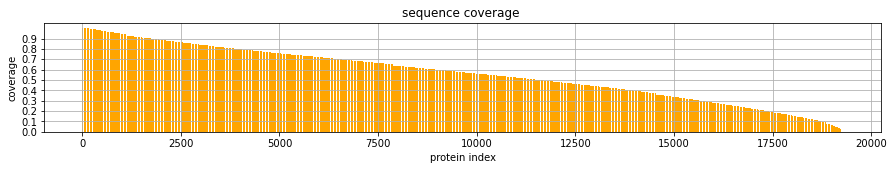

In [21]:
plt.figure(figsize=(15,2))
plt.bar(range(len(df_cover)), df_cover.coverage.values, color='orange')

plt.title('sequence coverage ')
plt.xlabel('protein index')
plt.ylabel('coverage')
plt.yticks(list(np.arange(0, 1, 0.1)))
plt.grid()
plt.show()

In [18]:
THRESHOLD = 0.5
remain_prot = df_cover.loc[df_cover.coverage>=THRESHOLD].protein.values
print('after protein sequence coverage >= 0.5 filtration : ', len(remain_prot))

digest_prot = remain_prot[:int(len(remain_prot)/2)]
detect_prot = remain_prot[int(len(remain_prot)/2):]

digest_idx = [idx for idx, _ in enumerate(df_ided_protein.PROTEIN.values) if _ in digest_prot]
detect_idx = [idx for idx, _ in enumerate(df_ided_protein.PROTEIN.values) if _ in detect_prot]
df_digest_protein = df_ided_protein.loc[digest_idx].reset_index(drop=True)
df_detect_protein = df_ided_protein.loc[detect_idx].reset_index(drop=True)
print(df_digest_protein.shape, df_detect_protein.shape)

after protein sequence coverage >= 0.5 filtration :  11707
(5853, 5) (5854, 5)


In [23]:
df_digest_protein.to_csv('data/uniprot/df_digest_protein.csv', index=False)
df_detect_protein.to_csv('data/uniprot/df_detect_protein.csv', index=False)

# 2. Detect_pep, unDetect_pep

In [19]:
df_detect_peptide = pep_detection_labelling(df_ided_protein = df_detect_protein)

del rows(including U, X amino acid) cnt : 50
peptide with 1 spectral count (remove this peptide) cnt :  30370
----ID/nonID cnt----
 0    496741
1    168244
Name: ID, dtype: int64
----final shape----
 (664985, 8)


In [24]:
df_detect_peptide = pep_detection_labelling(df_ided_protein = df_detect_protein)

del rows(including U, X amino acid) cnt : 50
peptide with 1 spectral count (remove this peptide) cnt :  30370
----ID/nonID cnt----
 0    496741
1    168244
Name: ID, dtype: int64
----final shape----
 (664985, 8)


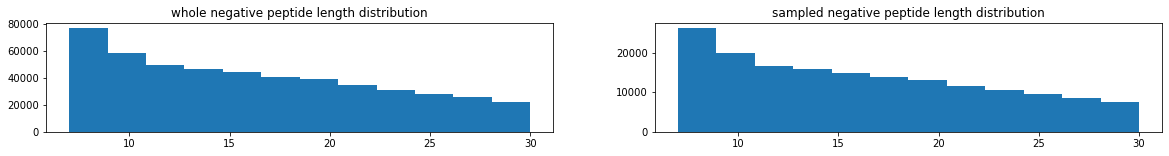

In [25]:
# check undersampling distribution
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 2)
ax[0].hist(df_detect_peptide.loc[df_detect_peptide.ID==0].PEP.apply(lambda x: len(x)).values, bins=12)
ax[0].set_title('whole negative peptide length distribution')
ax[1].hist(df_detect_peptide.loc[df_detect_peptide.ID==0].sample(168244, random_state=7).PEP.apply(lambda x: len(x)).values, bins=12)
ax[1].set_title('sampled negative peptide length distribution')
plt.show()

In [26]:
df_detect_peptide.to_csv('data/uniprot/df_detect_peptide.csv', index=False)

In [27]:
df_digest_peptide = pep_detection_labelling(df_ided_protein = df_digest_protein)

del rows(including U, X amino acid) cnt : 33
peptide with 1 spectral count (remove this peptide) cnt :  32101
----ID/nonID cnt----
 0    318486
1    245223
Name: ID, dtype: int64
----final shape----
 (563709, 8)


In [28]:
# detect 데이터에 있는 펩타이드 제거
df_key = pd.DataFrame([[_, True] for _ in df_detect_peptide.PEP.unique()], columns=['PEP', 'Drop'])
before=df_digest_peptide.shape[0]
df_digest_peptide_drop = df_digest_peptide.merge(df_key, on='PEP', how='left')
df_digest_peptide_drop = df_digest_peptide_drop.loc[df_digest_peptide_drop.Drop.isnull()].drop('Drop', axis=1).reset_index(drop=True)
after=df_digest_peptide_drop.shape[0]
print(before, after, before-after)

563709 553050 10659


In [29]:
hold = df_detect_peptide.sample(frac=0.4, random_state=7)
train = df_detect_peptide.drop(hold.index, axis=0)
print('---sampled ID/nonID cnt---\n', df_detect_peptide.ID.value_counts(),
      '\n---holdout ID/nonID cnt---\n', hold.ID.value_counts(),
      '\n---train   ID/nonID cnt---\n', train.ID.value_counts())

---sampled ID/nonID cnt---
 0    496741
1    168244
Name: ID, dtype: int64 
---holdout ID/nonID cnt---
 0    198998
1     66996
Name: ID, dtype: int64 
---train   ID/nonID cnt---
 0    297743
1    101248
Name: ID, dtype: int64


In [30]:
df_key = pd.DataFrame([[_, True] for _ in hold.PEP.unique()], columns=['PEP', 'Drop'])
before=train.shape[0]
train_drop = train.merge(df_key, on='PEP', how='left')
train_drop = train_drop.loc[train_drop.Drop.isnull()].drop('Drop', axis=1).reset_index(drop=True)
after=train_drop.shape[0]
print(before, after, before-after)

398991 389738 9253


In [31]:
df_digest_peptide_drop.ID.value_counts()

0    312416
1    240634
Name: ID, dtype: int64

In [32]:
df_train = pd.concat([train_drop, df_digest_peptide_drop], axis=0).reset_index(drop=True)
df_train.ID.value_counts()

0    603090
1    339698
Name: ID, dtype: int64

In [33]:
p = hold.loc[hold.ID==1]
n = hold.loc[hold.ID==0].sample(len(p), random_state=7)
print(len(p), len(n))
hold_sampled = pd.concat([p, n], axis=0).reset_index(drop=True)

66996 66996


In [34]:
p = df_train.loc[df_train.ID==1]
n = df_train.loc[df_train.ID==0].sample(len(p), random_state=7)
print(len(p), len(n))
df_train_sampled = pd.concat([p, n], axis=0).reset_index(drop=True)

339698 339698


* unDetectable sampling

In [35]:
hold_sampled.to_csv('data/df_detect_peptide_test.csv', index=False)
df_train_sampled.to_csv('data/df_detect_peptide_train.csv', index=False)

# poster viz

In [7]:
df_train_sampled.loc[df_train_sampled.PEP=='GTAAAAAAAAAAK']

,peptide,En,Ec,E1,E2,protein,PEP,ID
181290,K.GTAAAAAAAAAAK.V,PKKAPGTKGTAAAAA,AAAAAAAKVPAKKIT,-,-,sp|P50914|RL14_HUMAN,GTAAAAAAAAAAK,1


In [11]:
viz = df_ided_protein.loc[df_ided_protein.PROTEIN=='sp|P50914|RL14_HUMAN']
viz

,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
15140,sp|P50914|RL14_HUMAN,MVFRRFVEVGRVAYVSFGPHAGKLVAIVDVIDQNRALVDGPCTQVR...,>sp|P50914|RL14_HUMAN 60S ribosomal protein L1...,M_1;V_0;F_0;R_0;R_22;F_12;V_0;E_0;V_0;G_0;R_24...,M_1;V_1;F_1;R_1;R_23;F_35;V_35;E_35;V_35;G_35;...


In [16]:
sc = list(map(int, [_[2:] for _ in viz.SPECTRAL_CNT.values[0].split(';')]))
mc = list(map(int, [_[2:] for _ in viz.SPECTRAL_CNT_MISS.values[0].split(';')]))

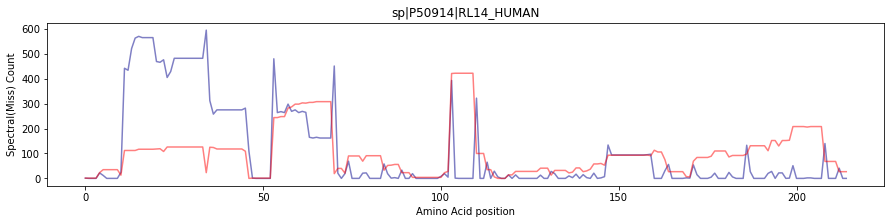

In [26]:
plt.figure(figsize=(15,3))
x = range(len(sc))
plt.plot(x, sc, color='darkblue', label='SpectralCount', alpha=0.5)
plt.plot(x, mc, color='red', label='MissCount', alpha=0.5)
plt.title('sp|P50914|RL14_HUMAN')
plt.xlabel('Amino Acid position')
plt.ylabel('Spectral(Miss) Count')
plt.show()

In [9]:
import matplotlib.pyplot as plt

In [7]:
train_neg = {8: 44935, 28: 17899, 6: 67746, 30: 15274, 5: 63599, 4: 16533, 32: 14013, 29: 15858, 7: 59060, 9: 38966, 31: 14935, 14: 30268, 33: 13268, 39: 8558, 11: 32601, 22: 23269, 25: 20147, 19: 27527, 40: 8277, 35: 11352, 10: 34916, 37: 10161, 42: 7760, 17: 27165, 15: 29542, 41: 8102, 12: 31704, 13: 31677, 34: 12285, 20: 24756, 24: 21300, 26: 18968, 36: 10996, 23: 22326, 27: 18028, 38: 9554, 18: 27062, 59: 1994, 55: 2649, 74: 643, 66: 1204, 84: 326, 54: 2914, 43: 6876, 50: 3894, 46: 5492, 53: 3192, 63: 1562, 44: 6416, 21: 24154, 16: 28378, 68: 1028, 64: 1401, 47: 5085, 61: 1708, 51: 3709, 49: 4249, 60: 1832, 75: 638, 48: 4666, 52: 3424, 57: 2329, 62: 1558, 56: 2440, 76: 556, 71: 804, 82: 381, 80: 420, 58: 2106, 45: 6019, 67: 1132, 70: 866, 109: 77, 118: 45, 81: 423, 69: 973, 78: 495, 65: 1240, 77: 567, 72: 747, 100: 118, 111: 60, 73: 706, 90: 190, 89: 250, 106: 59, 143: 16, 83: 364, 105: 77, 112: 57, 97: 146, 85: 320, 87: 262, 120: 43, 79: 422, 103: 94, 101: 116, 113: 55, 147: 13, 104: 99, 88: 240, 107: 66, 92: 188, 96: 153, 99: 111, 91: 215, 93: 196, 94: 160, 86: 276, 116: 52, 117: 51, 98: 119, 114: 50, 102: 102, 108: 76, 129: 39, 141: 13, 124: 34, 119: 30, 148: 14, 142: 17, 220: 4, 136: 18, 162: 8, 110: 61, 115: 56, 145: 12, 128: 32, 135: 19, 140: 17, 168: 9, 211: 5, 234: 2, 239: 1, 95: 130, 134: 17, 121: 52, 126: 26, 125: 33, 132: 25, 139: 18, 193: 2, 203: 5, 195: 3, 150: 15, 184: 4, 170: 7, 165: 9, 155: 7, 182: 5, 127: 31, 152: 13, 161: 12, 167: 8, 166: 6, 172: 7, 131: 18, 151: 11, 164: 5, 174: 11, 188: 4, 189: 4, 122: 31, 177: 8, 157: 12, 191: 7, 146: 18, 216: 3, 196: 4, 137: 17, 133: 17, 185: 6, 178: 5, 176: 3, 200: 3, 208: 4, 221: 2, 123: 36, 138: 18, 154: 8, 317: 1, 318: 1, 325: 1, 230: 2, 217: 2, 130: 34, 202: 2, 197: 3, 204: 4, 210: 3, 192: 5, 181: 4, 228: 3, 232: 3, 156: 11, 3: 8, 158: 11, 153: 8, 186: 6, 175: 9, 201: 4, 206: 4, 226: 2, 231: 2, 159: 13, 160: 10, 171: 7, 246: 1, 265: 2, 215: 2, 242: 1, 179: 7, 183: 4, 190: 4, 207: 4, 235: 3, 357: 1, 209: 2, 213: 3, 144: 13, 311: 1, 319: 1, 194: 2, 149: 9, 198: 8, 163: 8, 543: 1, 335: 1, 549: 1, 342: 2, 241: 1, 199: 4, 205: 2, 212: 3, 219: 3, 173: 5, 187: 4, 169: 4, 223: 1, 274: 1, 257: 1, 263: 2, 277: 1, 258: 1, 292: 2, 283: 1, 286: 1, 229: 2, 224: 3, 248: 1, 222: 1, 290: 1, 297: 2, 236: 3, 285: 1, 341: 1, 344: 1, 353: 2, 308: 1, 237: 2, 218: 1, 267: 1, 240: 1, 233: 1, 238: 1, 303: 1, 314: 1, 343: 1, 322: 1, 273: 1, 243: 1, 225: 1, 253: 2, 249: 1, 251: 1, 227: 1}
train_neg_sam = {28: 6007, 17: 8922, 16: 9364, 21: 8142, 8: 14951, 6: 22491, 29: 5250, 27: 6012, 50: 1308, 5: 20889, 23: 7366, 26: 6286, 22: 7678, 43: 2353, 18: 8895, 30: 5089, 12: 10441, 34: 4076, 57: 808, 10: 11355, 4: 5474, 33: 4422, 37: 3397, 44: 2080, 19: 9110, 25: 6618, 48: 1554, 51: 1266, 31: 5031, 14: 10011, 15: 9773, 7: 19649, 35: 3728, 40: 2753, 11: 10833, 9: 12911, 55: 851, 71: 288, 86: 98, 32: 4708, 13: 10541, 20: 8121, 24: 6977, 65: 385, 93: 79, 66: 423, 79: 128, 54: 942, 38: 3134, 36: 3741, 62: 497, 53: 1040, 41: 2683, 39: 2861, 46: 1819, 47: 1664, 61: 553, 42: 2585, 49: 1398, 52: 1134, 64: 474, 91: 74, 78: 152, 63: 487, 56: 757, 45: 1988, 60: 581, 69: 312, 68: 317, 126: 8, 171: 3, 76: 188, 82: 118, 73: 241, 67: 361, 77: 186, 59: 624, 80: 144, 70: 303, 114: 16, 81: 170, 72: 226, 84: 115, 74: 215, 58: 685, 87: 87, 98: 44, 75: 214, 224: 2, 106: 23, 186: 3, 95: 38, 83: 124, 89: 83, 103: 35, 101: 38, 125: 14, 135: 8, 94: 58, 90: 60, 120: 12, 85: 97, 194: 1, 119: 9, 146: 5, 187: 2, 96: 53, 92: 67, 181: 2, 108: 16, 99: 27, 147: 8, 112: 24, 283: 1, 130: 8, 123: 23, 110: 21, 88: 85, 178: 2, 104: 36, 97: 41, 145: 5, 105: 29, 102: 28, 129: 14, 113: 20, 179: 4, 100: 35, 115: 20, 137: 4, 132: 7, 210: 1, 124: 13, 286: 1, 172: 3, 144: 5, 121: 13, 122: 11, 109: 26, 107: 23, 111: 18, 150: 5, 157: 3, 248: 1, 164: 3, 158: 4, 140: 3, 206: 1, 216: 3, 236: 1, 174: 3, 127: 12, 128: 11, 142: 5, 220: 1, 143: 4, 136: 5, 131: 7, 152: 1, 117: 15, 159: 6, 116: 13, 198: 4, 549: 1, 161: 4, 207: 2, 148: 6, 139: 6, 200: 1, 202: 1, 155: 2, 118: 13, 199: 1, 138: 4, 165: 4, 237: 1, 191: 2, 149: 4, 185: 4, 156: 3, 141: 4, 175: 1, 154: 3, 341: 1, 160: 2, 168: 4, 221: 1, 190: 2, 208: 1, 3: 2, 134: 2, 318: 1, 196: 1, 177: 2, 133: 4, 183: 2, 265: 2, 201: 2, 153: 2, 297: 1, 167: 2, 163: 1, 353: 2, 182: 3, 203: 4, 277: 1, 205: 1, 192: 1, 173: 1, 169: 2, 170: 3, 342: 1, 218: 1, 235: 1, 197: 1, 335: 1, 189: 1, 251: 1, 211: 1, 166: 2, 184: 1, 246: 1, 162: 1, 257: 1, 193: 1, 263: 1, 317: 1, 151: 1, 195: 1}

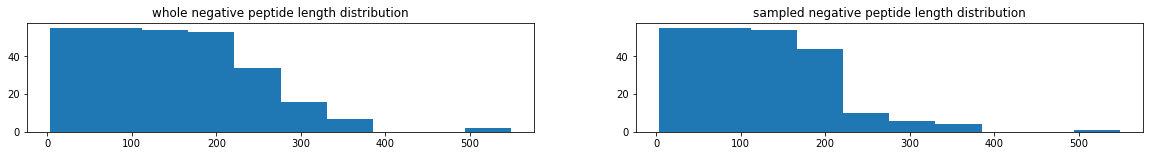

In [10]:
# check undersampling distribution
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 2)
ax[0].hist(train_neg)
ax[0].set_title('whole negative peptide length distribution')
ax[1].hist(train_neg_sam)
ax[1].set_title('sampled negative peptide length distribution')
plt.show()

In [16]:
test_neg = {208: 1, 43: 1749, 20: 6267, 1: 22015, 26: 4845, 5: 19742, 47: 1276, 17: 6891, 94: 36, 9: 10425, 22: 6065, 29: 4081, 11: 8221, 7: 15070, 3: 20955, 41: 2106, 18: 6813, 46: 1404, 21: 6120, 13: 7980, 32: 3629, 48: 1137, 14: 7560, 8: 11507, 27: 4585, 35: 2850, 12: 8352, 16: 7199, 19: 7097, 28: 4492, 4: 20105, 10: 8894, 2: 21664, 15: 7601, 30: 3932, 72: 189, 6: 18699, 31: 3837, 112: 10, 66: 298, 37: 2562, 63: 362, 39: 2184, 74: 170, 40: 1938, 38: 2251, 84: 98, 34: 3187, 25: 5211, 23: 5425, 51: 972, 49: 1031, 33: 3334, 52: 882, 24: 5361, 60: 433, 62: 363, 53: 822, 36: 2724, 104: 21, 70: 242, 73: 159, 57: 549, 58: 515, 44: 1583, 45: 1536, 54: 800, 42: 1873, 59: 497, 61: 424, 123: 6, 65: 320, 71: 195, 87: 66, 79: 109, 55: 639, 50: 1088, 56: 656, 78: 119, 69: 227, 120: 10, 75: 166, 90: 51, 67: 279, 82: 87, 92: 45, 134: 4, 64: 319, 89: 59, 93: 45, 97: 42, 81: 103, 91: 42, 107: 18, 96: 37, 68: 256, 85: 89, 100: 33, 130: 5, 80: 107, 77: 129, 83: 85, 122: 8, 95: 29, 150: 7, 88: 81, 105: 22, 146: 2, 86: 69, 76: 129, 125: 7, 133: 6, 126: 7, 99: 39, 110: 15, 106: 18, 98: 39, 180: 2, 109: 17, 175: 4, 215: 1, 115: 22, 193: 2, 117: 12, 317: 2, 118: 13, 113: 15, 184: 2, 231: 1, 136: 3, 151: 4, 189: 3, 108: 19, 212: 3, 102: 31, 103: 17, 156: 5, 128: 6, 205: 1, 174: 3, 127: 13, 207: 2, 329: 2, 101: 22, 138: 5, 227: 2, 204: 1, 171: 2, 116: 14, 206: 4, 165: 2, 119: 8, 114: 14, 164: 1, 147: 4, 273: 1, 182: 3, 170: 1, 153: 2, 121: 6, 166: 2, 139: 5, 135: 3, 111: 13, 148: 2, 160: 3, 132: 5, 154: 3, 137: 3, 243: 1, 169: 2, 124: 6, 168: 3, 141: 2, 252: 2, 195: 1, 159: 3, 552: 1, 143: 5, 140: 4, 131: 2, 167: 3, 176: 3, 181: 2, 162: 1, 157: 7, 218: 1, 129: 7, 194: 1, 179: 2, 144: 4, 161: 2, 278: 1, 223: 1, 173: 1, 331: 1, 142: 2, 186: 1, 152: 2, 198: 2, 145: 2, 260: 3, 183: 1, 178: 1, 363: 1, 163: 1, 284: 1, 246: 1, 190: 1, 149: 1, 158: 1, 256: 1, 255: 1, 172: 1, 214: 1, 225: 1, 191: 1, 242: 1}
test_neg_sam = {3: 5385, 40: 497, 13: 2047, 6: 4742, 17: 1801, 4: 5096, 23: 1317, 1: 5583, 2: 5548, 24: 1390, 11: 2038, 37: 641, 36: 689, 30: 1012, 25: 1328, 61: 102, 7: 3827, 15: 2002, 31: 931, 10: 2228, 9: 2643, 26: 1179, 47: 298, 5: 4907, 59: 123, 21: 1611, 8: 2842, 45: 393, 14: 1906, 38: 552, 51: 262, 28: 1149, 32: 878, 56: 164, 18: 1747, 22: 1549, 42: 472, 19: 1681, 34: 780, 20: 1610, 16: 1848, 33: 856, 46: 361, 43: 432, 27: 1143, 44: 376, 53: 193, 12: 2154, 65: 91, 41: 575, 50: 289, 29: 1043, 76: 24, 52: 229, 55: 159, 54: 199, 48: 292, 102: 13, 73: 39, 35: 700, 49: 272, 81: 23, 75: 44, 39: 579, 58: 125, 552: 1, 63: 93, 84: 32, 66: 76, 78: 31, 57: 130, 67: 60, 82: 17, 94: 10, 90: 11, 64: 72, 92: 13, 70: 66, 83: 23, 176: 1, 69: 56, 62: 89, 95: 6, 80: 27, 165: 2, 93: 13, 110: 4, 72: 47, 124: 1, 140: 2, 89: 12, 60: 128, 91: 11, 79: 28, 87: 18, 85: 29, 86: 12, 215: 1, 112: 1, 77: 39, 71: 35, 107: 3, 74: 48, 108: 4, 68: 55, 97: 11, 98: 5, 115: 6, 126: 2, 151: 2, 100: 12, 148: 1, 88: 23, 141: 1, 96: 7, 129: 3, 105: 4, 111: 5, 128: 1, 175: 1, 103: 3, 255: 1, 117: 4, 146: 1, 99: 15, 212: 3, 189: 1, 116: 4, 167: 1, 125: 2, 118: 3, 109: 6, 120: 2, 273: 1, 121: 2, 104: 4, 123: 2, 186: 1, 184: 1, 153: 1, 256: 1, 156: 1, 106: 3, 113: 4, 194: 1, 152: 1, 137: 1, 122: 1, 168: 1, 163: 1, 127: 3, 114: 4, 154: 1, 193: 1, 132: 2, 191: 1, 101: 6, 166: 1, 164: 1, 133: 1, 171: 1, 130: 1, 149: 1, 161: 1, 206: 1, 218: 1, 144: 1, 145: 1, 119: 1, 158: 1}

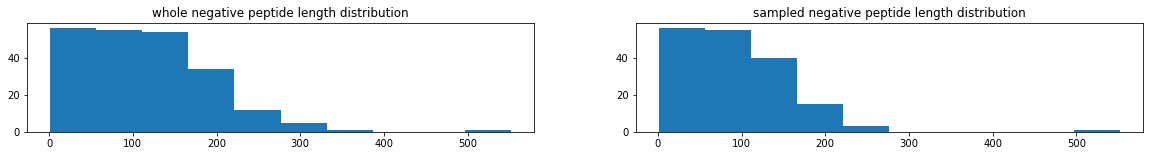

In [17]:
# check undersampling distribution
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 2)
ax[0].hist(test_neg)
ax[0].set_title('whole negative peptide length distribution')
ax[1].hist(test_neg_sam)
ax[1].set_title('sampled negative peptide length distribution')
plt.show()